# Open experimental data

In [16]:
import os
import aedat
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

path = '/home/INT/grimaldi.a/Documents/projets/WP3/07_08_2021_field_data_collection'
list = os.listdir(path)
print(f'list of all files : \n {list}')

if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/model/')
    os.mkdir('../Records/train/')
    os.mkdir('../Records/test/')
if not os.path.exists('../Data/'):
    os.mkdir('../Data/')

labelz = [0] # to change!
t_index_file, x_index_file, y_index_file, p_index_file = 0, 1, 2, 3
x_index, y_index, t_index, p_index = 0, 1, 2, 3

patch_R = 16
duration = None
min_events = 20
#duration = int(1e7)


#you can load the data and make patches on the pixel grid to divide the DVS 
#recordings and obtain more samples
def load_data_patches(path, rec_number, patch_size, time_limit, min_events):
    f_name = f'../Data/aprovisexp_{patch_size}_{rec_number}_{time_limit}_{min_events}.pkl'
    if os.path.isfile(f_name):
        with open(f_name, 'rb') as file:
            events_stacked, label_stacked, indices = pickle.load(file)
    else:
        events_stacked = np.array([])
        label_stacked = []
        indices = [0]
        for num in rec_number:
            fname_aedat = f'{path}/{list[num]}'
            decoder = aedat.Decoder(fname_aedat)
            events_list = np.array([])
            # this use of the decoder is not optimal at all, to be improved
            for packet in decoder:
                for i in range(len(packet['events'])):
                    events_list = np.vstack([events_list, np.array([packet['events'][i][x_index_file], packet['events'][i][y_index_file], packet['events'][i][t_index_file], packet['events'][i][p_index_file]])]) if events_list.size else np.array([packet['events'][i][x_index_file], packet['events'][i][y_index_file], packet['events'][i][t_index_file], packet['events'][i][p_index_file]])
            initial_time = events_list[0,t_index]
            events_list[:,t_index] -= initial_time
            label = labelz[0]
            print(f'file name: {list[num]} \n total number of events: {len(events_list)} \n recording time: {events_list[-1,t_index]*1e-6} sec \n \n')
            width, height = 128, 128
            pbar = tqdm(total=width//patch_size*height//patch_size)
            for x in range(width//patch_size):
                for y in range(height//patch_size):
                    events_patch = events_list[
                                   (events_list[:,x_index]>=x*patch_size)&(events_list[:,x_index]<(x+1)*patch_size)&
                                   (events_list[:,y_index]>=y*patch_size)&(events_list[:,y_index]<(y+1)*patch_size)]
                    events_patch[:,x_index] -= x*patch_size
                    events_patch[:,y_index] -= y*patch_size
    #                if time_limit:
    #                    time = 0
    #                    events_patch[:,t_index] = events_patch[(events_patch[:,t_index]<time)]
                    if len(events_patch)<min_events:
                        pass
                    else:
                        events_patch[:,t_index] -= np.min(events_patch[:,t_index])
                        indices.append(indices[-1]+events_patch.shape[0])
                        label_stacked.append(label)
                        events_stacked = np.vstack([events_stacked, events_patch]) if events_stacked.size else events_patch
                    pbar.update(1)
            # print(np.max(events_patch[:,x_index]), np.max(events_patch[:,y_index]), np.max(events_patch[:,t_index]))
            pbar.close()
            decoder = None
        with open(f_name, 'wb') as file:
            pickle.dump([events_stacked, label_stacked, indices], file, pickle.HIGHEST_PROTOCOL)
    return events_stacked, label_stacked, indices

list of all files : 
 ['DVS128-2021-08-07T09-54-36+0300-Bern13XX-0.aedat4', 'DVS128-2021-08-07T09-09-27+0300-Bern13XX-0.aedat4', 'DVS128-2021-08-07T10-00-09+0300-Bern13XX-0.aedat4', 'DVS128-2021-08-07T09-28-28+0300-Bern13XX-0.aedat4', 'DVS128-2021-08-07T10-16-37+0300-Bern13XX-0.aedat4']


In [2]:
#load and save the data (select specific recordings for the training or testing set
#here only one recording to train because the views are not labeled)
events_train, label_train, indices_train = load_data_patches(path, [0], patch_R, duration, min_events)

NameError: name 'load_data_patches' is not defined

In [ ]:
print(f'averaged number of events per sample: {np.round(events_train.shape[0]/len(indices_train))}')

In [4]:
events_test, label_test, indices_test = load_data_patches(path, [0,2], patch_R, duration, min_events)

There are way more events for ground compare to sea data

# Train the MLR model on this dataset

In [9]:
import torch
from HOTS.Tools import LRtorch, classification_numbevents

num_workers = 0 # ajouter num_workers si besoin!
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
sample_space = 1
tau_cla = 1e6
jitonic = [None, None]
subset_size = None
verbose=True
dataset = 'aprovisynt'
nb_pola = 2
N = patch_R*patch_R*nb_pola

In [10]:
def fit_MLR(events_train, label_train, indices_train, tau_cla, patch_R):
    num_workers = 0 # ajouter num_workers si besoin!
    learning_rate = 0.005
    beta1, beta2 = 0.9, 0.999
    betas = (beta1, beta2)
    num_epochs = 2 ** 5 + 1
    sample_space = 1
    jitonic = [None, None]
    subset_size = None
    verbose=True
    dataset = 'aprovisynt'
    nb_pola = 2
    N = patch_R*patch_R*nb_pola
    
    nb_digit = len(indices_train)

    transform = tonic.transforms.Compose([tonic.transforms.ToTimesurface(surface_dimensions=False, tau=tau_cla, decay="exp", merge_polarities=False)])
    train_dataset = AERDataset(tensors=(events_train, label_train), indices=indices_train, name = 'aprovisynt', transform=transform)
    loader = DataLoader(train_dataset, shuffle=True)

    torch.set_default_tensor_type("torch.DoubleTensor")
    criterion = torch.nn.BCELoss(reduction="mean")
    amsgrad = True #or False gives similar results
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if verbose:
        print(f'device -> {device} - num workers -> {num_workers}')

    n_classes = len(train_dataset.classes)
    logistic_model = LRtorch(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    pbar = tqdm(total=int(num_epochs))
    for epoch in range(int(num_epochs)):
        losses = []
        for X, label in loader:
            X, label = X[0].to(device) ,label[0].to(device)
            X = X.reshape(X.shape[0], N)
            outputs = logistic_model(X)

            n_events = X.shape[0]
            labels = label*torch.ones(n_events).type(torch.LongTensor).to(device)
            labels = torch.nn.functional.one_hot(labels, num_classes=n_classes).type(torch.DoubleTensor).to(device)

            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f'loss for epoch number {epoch}: {loss}')
        pbar.update(1)

    pbar.close()
    with open(f'../Records/model/torch_model_{tau_cla}_{patch_R}.pkl', 'wb') as file:
        pickle.dump([logistic_model, losses], file, pickle.HIGHEST_PROTOCOL)
    return logistic_model, losses

In [ ]:
logistic_model, losses = fit_MLR(events_train, label_train, indices_train, tau_cla, patch_R)

device -> cuda - num workers -> 0


  3%|████▎                                                                                                                                         | 1/33 [05:48<3:05:47, 348.36s/it]

loss for epoch number 0: 0.5944622111529847


  6%|████████▌                                                                                                                                     | 2/33 [11:26<2:56:57, 342.51s/it]

loss for epoch number 1: 0.518935940178484


  9%|████████████▉                                                                                                                                 | 3/33 [17:10<2:51:37, 343.26s/it]

loss for epoch number 2: 0.18026937411587488


 12%|█████████████████▏                                                                                                                            | 4/33 [22:48<2:44:48, 340.97s/it]

loss for epoch number 3: 0.09166800830549238


 15%|█████████████████████▌                                                                                                                        | 5/33 [28:32<2:39:37, 342.06s/it]

loss for epoch number 4: 0.2560523270769089


 18%|█████████████████████████▊                                                                                                                    | 6/33 [34:18<2:34:28, 343.29s/it]

loss for epoch number 5: 0.5154303404250081


 21%|██████████████████████████████                                                                                                                | 7/33 [40:03<2:29:05, 344.06s/it]

loss for epoch number 6: 0.5267742062830822


 24%|██████████████████████████████████▍                                                                                                           | 8/33 [45:49<2:23:33, 344.55s/it]

loss for epoch number 7: 0.48326569943036246


 27%|██████████████████████████████████████▋                                                                                                       | 9/33 [51:34<2:17:56, 344.85s/it]

loss for epoch number 8: 0.44446902939139854


 30%|██████████████████████████████████████████▋                                                                                                  | 10/33 [57:19<2:12:11, 344.86s/it]

loss for epoch number 9: 0.22967189387281625


 33%|██████████████████████████████████████████████▎                                                                                            | 11/33 [1:03:05<2:06:34, 345.20s/it]

loss for epoch number 10: 0.07370376067358542


 36%|██████████████████████████████████████████████████▌                                                                                        | 12/33 [1:08:51<2:00:55, 345.52s/it]

loss for epoch number 11: 0.024918817003491616


 39%|██████████████████████████████████████████████████████▊                                                                                    | 13/33 [1:14:37<1:55:11, 345.56s/it]

loss for epoch number 12: 0.08807035410152327


 42%|██████████████████████████████████████████████████████████▉                                                                                | 14/33 [1:20:24<1:49:36, 346.12s/it]

loss for epoch number 13: 0.03588291748553633


 45%|███████████████████████████████████████████████████████████████▏                                                                           | 15/33 [1:26:15<1:44:14, 347.47s/it]

loss for epoch number 14: 0.025751075656938058


 48%|███████████████████████████████████████████████████████████████████▍                                                                       | 16/33 [1:32:16<1:39:37, 351.65s/it]

loss for epoch number 15: 0.04820868039888258


 52%|███████████████████████████████████████████████████████████████████████▌                                                                   | 17/33 [1:38:00<1:33:08, 349.25s/it]

loss for epoch number 16: 0.24441162567871005


 55%|███████████████████████████████████████████████████████████████████████████▊                                                               | 18/33 [1:43:43<1:26:50, 347.33s/it]

loss for epoch number 17: 0.09717107712905806


 58%|████████████████████████████████████████████████████████████████████████████████                                                           | 19/33 [1:49:25<1:20:41, 345.81s/it]

loss for epoch number 18: 0.052508626331754744


 61%|████████████████████████████████████████████████████████████████████████████████████▏                                                      | 20/33 [1:55:09<1:14:48, 345.26s/it]

loss for epoch number 19: 0.09827968865956782


 64%|████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 21/33 [2:00:53<1:08:58, 344.90s/it]

loss for epoch number 20: 0.07766202660277462


 67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 22/33 [2:06:37<1:03:11, 344.65s/it]

loss for epoch number 21: 0.14439399620072688


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 23/33 [2:12:23<57:29, 344.98s/it]

loss for epoch number 22: 0.029637334922204186


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 24/33 [2:18:07<51:41, 344.65s/it]

loss for epoch number 23: 0.03592544701688897


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 25/33 [2:23:44<45:37, 342.22s/it]

loss for epoch number 24: 0.23975008025733494


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 26/33 [2:29:24<39:51, 341.71s/it]

loss for epoch number 25: 0.04170355389943178


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 27/33 [2:35:01<34:01, 340.26s/it]

loss for epoch number 26: 0.06291298285565945


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 28/33 [2:40:50<28:34, 342.87s/it]

loss for epoch number 27: 0.05095172132700628


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 29/33 [2:46:31<22:49, 342.40s/it]

loss for epoch number 28: 0.16820862809894782


# Make testing dataset 

In [ ]:
thres = None
chance = .5

for tau_cla in [10000, 100000, 1000000, 10000000, 100000000]:
    
    if os.path.isfile(f'../Records/model/torch_model_{tau_cla}_{patch_R}.pkl'):
        with open(f'../Records/model/torch_model_{tau_cla}_{patch_R}.pkl', 'rb') as file:
            logistic_model, losses = pickle.load(file)
    else: 
        logistic_model, losses = fit_MLR(events_train, label_train, indices_train, tau_cla, patch_R)
    
    transform = tonic.transforms.Compose([tonic.transforms.ToTimesurface(surface_dimensions=False, tau=tau_cla, decay="exp", merge_polarities=False)])
    test_dataset = AERDataset(tensors=(events_test, label_test), indices=indices_test, name = 'aprovisynt', transform=transform)
    loader = DataLoader(test_dataset, shuffle=True)

    nb_test = len(loader)
    nb_digit = len(indices_test)

    torch.set_default_tensor_type("torch.DoubleTensor")
    criterion = torch.nn.BCELoss(reduction="mean")
    amsgrad = True #or False gives similar results
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if verbose:
        print(f'device -> {device} - num workers -> {num_workers}')

    n_classes = len(test_dataset.classes)
    logistic_model = LRtorch(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    pbar = tqdm(total=int(len(loader)))
    likelihood, true_target = [], []
    for X, label in loader:
        X, label = X[0].to(device) ,label[0].to(device)
        X = X.reshape(X.shape[0], N)
        outputs = logistic_model(X)

        n_events = X.shape[0]
        labels = label*torch.ones(n_events).type(torch.LongTensor).to(device)
        labels = torch.nn.functional.one_hot(labels, num_classes=n_classes).type(torch.DoubleTensor).to(device)

        likelihood.append(outputs.cpu().detach().numpy())
        true_target.append(label.cpu().numpy())
        pbar.update(1)
    pbar.close()
    meanac, onlinac, lastac, maxprobac, maxevac, maxevac_end, truepos, falsepos, lastev = classification_numbevents(likelihood, true_target, thres, nb_test, chance, lenmat=int(1e6))
    print(meanac, lastac, maxprobac, maxevac, maxevac_end)

device -> cuda - num workers -> 0


  3%|████▉                                                                                                                                                               | 1/33 [06:16<3:20:40, 376.25s/it]

loss for epoch number 0: 0.17467905925766614


  6%|█████████▉                                                                                                                                                          | 2/33 [12:36<3:15:39, 378.71s/it]

loss for epoch number 1: 0.17662391152887252


  9%|██████████████▉                                                                                                                                                     | 3/33 [18:55<3:09:23, 378.77s/it]

loss for epoch number 2: 0.11801718763535003


 12%|███████████████████▉                                                                                                                                                | 4/33 [25:13<3:02:53, 378.40s/it]

loss for epoch number 3: 0.16968010056796534


 15%|████████████████████████▊                                                                                                                                           | 5/33 [31:30<2:56:20, 377.87s/it]

loss for epoch number 4: 0.14130065193430724


 18%|█████████████████████████████▊                                                                                                                                      | 6/33 [37:45<2:49:37, 376.96s/it]

loss for epoch number 5: 0.30028180696686035


 21%|██████████████████████████████████▊                                                                                                                                 | 7/33 [44:04<2:43:37, 377.61s/it]

loss for epoch number 6: 0.3575622630333244


 24%|███████████████████████████████████████▊                                                                                                                            | 8/33 [50:22<2:37:22, 377.70s/it]

loss for epoch number 7: 0.2934739490393453


In [32]:
from HOTS.Tools import classification_numbevents
thres = None
nb_test = len(loader)
chance = .5
meanac, onlinac, lastac, maxprobac, maxevac, maxevac_end, truepos, falsepos, lastev = classification_numbevents(likelihood, true_target, thres, nb_test, chance, lenmat=int(1e6))

/home/INT/grimaldi.a/Documents/projets/HOTS/HOTS/HOTS/Tools.py:570: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


0 samples where not classified


In [36]:
print(meanac, lastac, maxprobac, maxevac, maxevac_end)

0.7602808618457754 0.47058823529411764 0.6323529411764706 0.75 0.75


ValueError: x and y must have same first dimension, but have shapes (556051,) and (1,)

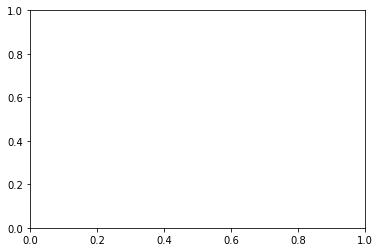

In [34]:
import matplotlib.pyplot as plt
plt.plot(onlinac)